In [1]:
import xarray as xr
from pathlib import Path
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from dask.diagnostics import ProgressBar
from sklearn.pipeline import Pipeline
from sklearn import linear_model
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV
import pandas as pd
from dask.distributed import Client
import joblib


In [33]:
cdir = Path('/storage/projects/goes_alg/combined/west/daytime')

In [442]:
files = list(cdir.glob('*.nc'))
print(len(files))
ds = xr.open_dataset(files[0], engine='h5netcdf')

399


In [440]:
ds.cloud_type.flag_meanings

array(['low overcast, transparent', 'low overcast, opaque',
       'transition, stratocumulus', 'low, broken cumulus',
       'altocumulus (transparent)', 'altostratus (opaque)',
       'cirrus (transparent)', 'deep convective (opaque)', 'no cloud'],
      dtype=object)

In [88]:
def preprocess(ds):
    da = xr.DataArray(np.tile(np.asarray(ds.encoding['source']), ds.dims['rec']), dims=("rec"))
    return ds.assign({'source': da})

* should completely separate day and night
* should look at distribution of top, thickness, and number of layers to ensure pretty even
* what about keeping day together vs totally new?

In [94]:
%%time 
combo_ds = xr.open_mfdataset(cdir.glob('*.nc'), combine='nested', concat_dim='rec', engine='h5netcdf', parallel=True,
                                   preprocess=preprocess)

CPU times: user 3min 42s, sys: 25.1 s, total: 4min 8s
Wall time: 3min 45s


In [95]:
combo_ds

<xarray.Dataset>
Dimensions:              (near: 16, rec: 488367)
Coordinates:
    x                    (rec, near) float32 dask.array<chunksize=(1480, 16), meta=np.ndarray>
    y                    (rec, near) float32 dask.array<chunksize=(1480, 16), meta=np.ndarray>
Dimensions without coordinates: near, rec
Data variables:
    cloud_top_altitude   (rec) float32 dask.array<chunksize=(1480,), meta=np.ndarray>
    cloud_thickness      (rec) float32 dask.array<chunksize=(1480,), meta=np.ndarray>
    cloud_base_altitude  (rec) float32 dask.array<chunksize=(1480,), meta=np.ndarray>
    cloud_layers         (rec) float32 dask.array<chunksize=(1480,), meta=np.ndarray>
    solar_azimuth        (rec) float32 dask.array<chunksize=(1480,), meta=np.ndarray>
    solar_zenith         (rec) float32 dask.array<chunksize=(1480,), meta=np.ndarray>
    cloud_type           (rec) uint8 dask.array<chunksize=(1480,), meta=np.ndarray>
    day_night_flag       (rec) int8 dask.array<chunksize=(1480,), meta=np

In [117]:
layers = combo_ds.cloud_layers.load()
type_ = combo_ds.cloud_type.load()

In [124]:
top = combo_ds.cloud_top_altitude.load()
thickness = combo_ds.cloud_thickness.load()


(array([3.1680e+03, 4.2360e+03, 1.6530e+03, 2.3830e+03, 1.9580e+03,
        3.0490e+03, 4.4480e+03, 6.0800e+03, 7.7520e+03, 1.0128e+04,
        9.7750e+03, 9.4980e+03, 8.8840e+03, 7.5390e+03, 7.3780e+03,
        6.8980e+03, 6.8660e+03, 6.6350e+03, 7.4240e+03, 6.9550e+03,
        6.9620e+03, 4.8830e+03, 7.2950e+03, 7.7870e+03, 8.6670e+03,
        1.0809e+04, 1.1074e+04, 1.2809e+04, 1.2373e+04, 1.2939e+04,
        1.1513e+04, 9.5300e+03, 8.1650e+03, 3.8390e+03, 2.2500e+03,
        1.9760e+03, 1.0670e+03, 3.2100e+02, 2.1500e+02, 1.4100e+02,
        7.3000e+01, 4.6000e+01, 3.0000e+01, 1.0000e+00, 3.0000e+00,
        2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00]),
 array([ 0.11263654,  0.49508187,  0.8775272 ,  1.2599725 ,  1.6424178 ,
         2.0248632 ,  2.4073083 ,  2.7897537 ,  3.172199  ,  3.5546443 ,
         3.9370897 ,  4.3195353 ,  4.70198   ,  5.0844254 ,  5.466871  ,
         5.849316  ,  6.2317615 ,  6.614207  ,  6.996652  ,  7.3790975 ,
      

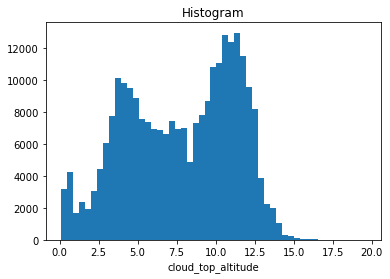

In [125]:
top.plot.hist(bins=51)

(array([1.2951e+04, 3.1044e+04, 4.1066e+04, 2.6615e+04, 2.1836e+04,
        1.6887e+04, 1.6633e+04, 1.2507e+04, 1.3250e+04, 9.9260e+03,
        9.7030e+03, 7.0380e+03, 7.1400e+03, 5.0450e+03, 5.1670e+03,
        3.3660e+03, 3.0750e+03, 3.1430e+03, 2.1830e+03, 2.0720e+03,
        1.4000e+03, 1.3940e+03, 1.0210e+03, 7.8300e+02, 5.6300e+02,
        4.8400e+02, 3.2800e+02, 2.8300e+02, 1.6000e+02, 1.6600e+02,
        8.0000e+01, 4.8000e+01, 4.6000e+01, 3.5000e+01, 1.8000e+01,
        7.0000e+00, 4.0000e+00, 5.0000e+00, 4.0000e+00, 3.0000e+00]),
 array([0.05987549, 0.20769516, 0.35551482, 0.5033345 , 0.65115416,
        0.79897386, 0.94679356, 1.0946132 , 1.2424328 , 1.3902526 ,
        1.5380722 , 1.6858919 , 1.8337116 , 1.9815313 , 2.129351  ,
        2.2771707 , 2.4249902 , 2.57281   , 2.7206297 , 2.8684492 ,
        3.016269  , 3.1640887 , 3.3119082 , 3.459728  , 3.6075478 ,
        3.7553673 , 3.903187  , 4.051007  , 4.1988263 , 4.346646  ,
        4.494466  , 4.6422853 , 4.790105  , 4.

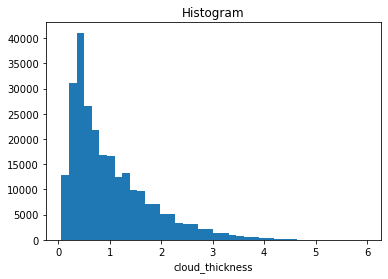

In [126]:
thickness.plot.hist(bins=40)

(array([2.31172e+05, 2.20391e+05, 3.50660e+04, 1.68900e+03, 4.60000e+01,
        2.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       dtype=float32),
 <a list of 10 Patch objects>)

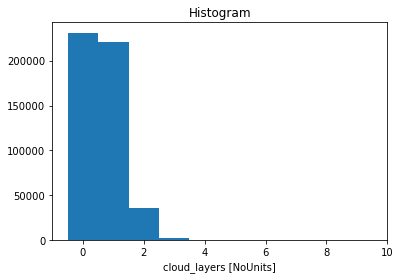

In [127]:
layers.plot.hist(bins=10, range=(0, 10), align='left')

In [ ]:
layers_wo_cld = combo_ds.cloud_layers[combo_ds.cloud_type == 8].compute()

In [119]:
layers[layers == 0].count()

<xarray.DataArray 'cloud_layers' ()>
array(230888)

In [122]:
type_[(type_ == 8) & (layers != 0)]

<xarray.DataArray 'cloud_type' (rec: 53)>
array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8], dtype=uint8)
Dimensions without coordinates: rec
Attributes:
    flag_values:    [0 1 2 3 4 5 6 7 8]
    flag_meanings:  ['low overcast, transparent' 'low overcast, opaque'\n 'tr...

(array([   804.,   6883.,  13764.,   6963.,  36898.,  35860.,  98320.,
         57934., 230941.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <a list of 9 Patch objects>)

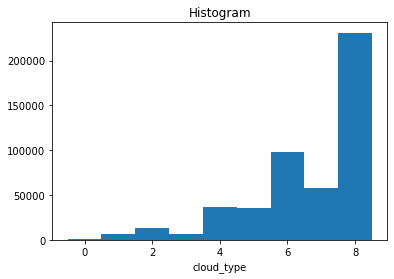

In [114]:
type_.plot.hist(bins=9, range=(0, 9), align='left')

(array([29523., 39650., 44021., 41237., 35090., 29787., 25557., 23704.,
        22461., 20016., 19509., 19833., 20781., 24262., 24419., 20893.,
        17758., 14295., 10368.,  5203.]),
 array([19.46462 , 22.199055, 24.933489, 27.667923, 30.402355, 33.13679 ,
        35.871223, 38.605656, 41.34009 , 44.074524, 46.80896 , 49.543392,
        52.27783 , 55.01226 , 57.746693, 60.48113 , 63.21556 , 65.95    ,
        68.68443 , 71.41886 , 74.1533  ], dtype=float32),
 <a list of 20 Patch objects>)

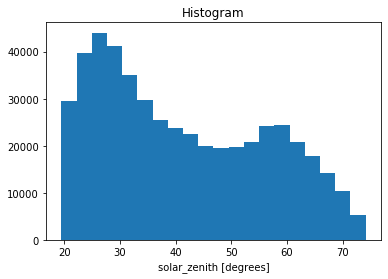

In [101]:
combo_ds.solar_zenith.plot.hist(bins=20)

In [131]:
type_.flag_meanings

array(['low overcast, transparent', 'low overcast, opaque',
       'transition, stratocumulus', 'low, broken cumulus',
       'altocumulus (transparent)', 'altostratus (opaque)',
       'cirrus (transparent)', 'deep convective (opaque)', 'no cloud'],
      dtype=object)

In [132]:
files = combo_ds.source.load()

In [151]:
from collections import defaultdict
counts = defaultdict(dict)
for f in np.unique(files):
    for i, meaning in enumerate(type_.flag_meanings):
        counts[f.item()][meaning] = ((files == f) & (type_ == i)).sum().item()

In [155]:
import pandas as pd
cdf = pd.DataFrame(counts).T

In [213]:
from sklearn.model_selection import train_test_split
train, alltest = train_test_split(cdf.index, train_size=0.7, )#stratify=cdf['low overcast, transparent'] > 0)

In [214]:
cdf.loc[train].mean()

low overcast, transparent      2.072464
low overcast, opaque          15.967391
transition, stratocumulus     33.815217
low, broken cumulus           18.760870
altocumulus (transparent)     93.373188
altostratus (opaque)          92.989130
cirrus (transparent)         242.438406
deep convective (opaque)     135.891304
no cloud                     585.757246
dtype: float64

In [215]:
cdf.loc[alltest].mean() 

low overcast, transparent      1.949580
low overcast, opaque          20.806723
transition, stratocumulus     37.235294
low, broken cumulus           15.000000
altocumulus (transparent)     93.504202
altostratus (opaque)          85.672269
cirrus (transparent)         263.924370
deep convective (opaque)     171.663866
no cloud                     582.117647
dtype: float64

In [389]:
val, test = train_test_split(alltest, train_size=0.5)

In [390]:
cdf.loc[val].mean()

low overcast, transparent      1.966102
low overcast, opaque          20.355932
transition, stratocumulus     32.101695
low, broken cumulus           15.983051
altocumulus (transparent)     93.898305
altostratus (opaque)          90.338983
cirrus (transparent)         293.491525
deep convective (opaque)     191.661017
no cloud                     575.966102
dtype: float64

In [391]:
cdf.loc[test].mean()

low overcast, transparent      1.933333
low overcast, opaque          21.250000
transition, stratocumulus     42.283333
low, broken cumulus           14.033333
altocumulus (transparent)     93.116667
altostratus (opaque)          81.083333
cirrus (transparent)         234.850000
deep convective (opaque)     152.000000
no cloud                     588.166667
dtype: float64

In [405]:
cdf.loc[train].index

Index(['/storage/projects/goes_alg/combined/west/daytime/20180630T210720_combined.nc',
       '/storage/projects/goes_alg/combined/west/daytime/20180704T204222_combined.nc',
       '/storage/projects/goes_alg/combined/west/daytime/20180410T202222_combined.nc',
       '/storage/projects/goes_alg/combined/west/daytime/20190212T202213_combined.nc',
       '/storage/projects/goes_alg/combined/west/daytime/20180619T212224_combined.nc',
       '/storage/projects/goes_alg/combined/west/daytime/20180629T202219_combined.nc',
       '/storage/projects/goes_alg/combined/west/daytime/20180330T204219_combined.nc',
       '/storage/projects/goes_alg/combined/west/daytime/20180715T202226_combined.nc',
       '/storage/projects/goes_alg/combined/west/daytime/20181027T205219_combined.nc',
       '/storage/projects/goes_alg/combined/west/daytime/20190102T203718_combined.nc',
       ...
       '/storage/projects/goes_alg/combined/west/daytime/20190410T202117_combined.nc',
       '/storage/projects/goes_a

In [420]:
train_recs = np.zeros(shape=files.shape)
for f in train:
    train_recs = np.logical_or(train_recs, files == f)

In [425]:
test_recs = np.zeros(shape=files.shape)
for f in test:
    test_recs = np.logical_or(test_recs, files == f)

In [426]:
val_recs = np.zeros(shape=files.shape)
for f in val:
    val_recs = np.logical_or(val_recs, files == f)

In [452]:
for f in train:
    p = Path(f)
    (p.parent / 'train' / p.name).symlink_to(p)

FileExistsError: [Errno 17] File exists: '/storage/projects/goes_alg/combined/west/daytime/20180301T211222_combined.nc' -> '/storage/projects/goes_alg/combined/west/daytime/train/20180301T211222_combined.nc'

In [ ]:
for f in test:
    p = Path(f)
    (p.parent / 'test' / p.name).symlink_to(p)

In [ ]:
for f in val:
    p = Path(f)
    (p.parent / 'validate' / p.name).symlink_to(p)

In [428]:
train_recs.sum(), val_recs.sum(), test_recs.sum()

(<xarray.DataArray 'source' ()>
 array(337014), <xarray.DataArray 'source' ()>
 array(77630), <xarray.DataArray 'source' ()>
 array(73723))

In [431]:
train_ds = combo_ds.sel(rec=train_recs)

In [434]:
np.unique(train_ds.source).sort() == train.values.sort()

True

In [444]:
train_ds.to_netcdf(cdir / 'train_set.nc', engine='h5netcdf') 

/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/h5netcdf/core.py:481: H5pyDeprecationWarning: other_ds.dims.create_scale(ds, name) is deprecated. Use ds.make_scale(name) instead.
  h5ds.dims.create_scale(h5ds, scale_name)


In [448]:
test_ds = combo_ds.sel(rec=test_recs)
assert np.unique(test_ds.source).sort() == test.values.sort()

True

In [449]:
val_ds = combo_ds.sel(rec=val_recs)
assert np.unique(val_ds.source).sort() == val.values.sort()

True

In [450]:
test_ds.to_netcdf(cdir / 'test_set.nc', engine='h5netcdf')

/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/h5netcdf/core.py:481: H5pyDeprecationWarning: other_ds.dims.create_scale(ds, name) is deprecated. Use ds.make_scale(name) instead.
  h5ds.dims.create_scale(h5ds, scale_name)


In [451]:
val_ds.to_netcdf(cdir / 'validate_set.nc', engine='h5netcdf')

/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/h5netcdf/core.py:481: H5pyDeprecationWarning: other_ds.dims.create_scale(ds, name) is deprecated. Use ds.make_scale(name) instead.
  h5ds.dims.create_scale(h5ds, scale_name)
